<a href="https://colab.research.google.com/github/tripidhoble/LTFS-Data-Science-FinHack-ML-Hackathon/blob/master/MFC_Capstone_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
pip install fuzzywuzzy

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
#import important libraries
from fuzzywuzzy import process
import re

In [0]:
path = "drive/My Drive/data/"

customer_df = pd.read_csv(path + 'customer.csv')
invoice_df = pd.read_csv(path + 'invoice.csv')
jtd_df = pd.read_csv(path + 'jtd.csv')
plant_df = pd.read_csv(path + 'plant.csv')
vehicles_df = pd.read_csv(path + 'vehicles.csv')

In [0]:
# 1. drop unwanted columns from all dataframes
# 2. lowercase all the categorical columns

def drop_col(dataset, col_to_drop):
    dataset.drop(col_to_drop, axis=1, inplace=True)
    return dataset

def lowercase(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    for col in categorical_col:
        dataset[col] = dataset[col].map(lambda x: x if type(x)!=str else x.lower())
    return dataset

invoice_columns_to_drop = ['Unnamed: 0', 'Amt Rcvd From Custom', 'Amt Rcvd From Ins Co','Area / Locality',
                           'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)',
                           'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
                           'Outstanding Amt', 'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
                           'Service Advisor Name', 'TDS amount', 'Total CGST', 'Total GST', 'Total IGST',
                           'Total SGST/UGST','Plant Name1','Recovrbl Exp']
customer_columns_to_drop = ['Unnamed: 0','Death date']
plant_columns_to_drop = ['Unnamed: 0','Name 1','Factory calendar','Valuation Area',
                         'Customer no. - plant','PO Box','Postal Code','Name 2',
                         'Vendor number plant','House number and street']
jtd_columns_to_drop = ['Unnamed: 0']
vehicles_columns_to_drop = ['Unnamed: 0','Product GUID']

dataframes = [invoice_df, customer_df, plant_df, jtd_df, vehicles_df]
dataframe_columns_to_drop = [invoice_columns_to_drop, customer_columns_to_drop, plant_columns_to_drop, jtd_columns_to_drop, vehicles_columns_to_drop]

for i in range(len(dataframes)):
  dataframes[i] = drop_col(dataframes[i],dataframe_columns_to_drop[i])
  dataframes[i] = lowercase(dataframes[i])

In [0]:

# Preprocessing for dataset merge operation

# 1. Remove leading zeros from 'Customer No.' column
def remove_leading_zeros(dataset,cols):
    for col in cols:
      dataset[col] = dataset[col].astype(str).apply(lambda x: x.lstrip("0"))
    return dataset
invoice_df  = remove_leading_zeros(invoice_df,['Customer No.'])
customer_df = remove_leading_zeros(customer_df,['Customer No.'])


# 2. Rename columns to use them as key column for merge operation
def rename_columns(dataset, rename_cols_dict):
    dataset.rename(columns=rename_cols_dict, inplace=True)
    return dataset
dict_invoice_df = {'District':'State'}
dict_vehicles_df = {'Vehicle Model':'Make', 'License Plate Number':'Regn No'}

invoice_df  = rename_columns(invoice_df, dict_invoice_df)
vehicles_df = rename_columns(vehicles_df, dict_vehicles_df)


# 3. Replace values in key columns for merge operation
def replacement(dataset, col, dict_replacement, regex=False):
    dataset[col] = dataset[col].replace(dict_replacement, regex=regex )
    return dataset
make_replacements = {
                    'mahindra &  mahindra': 'mahindra',
                    'tata motors': 'tata',
                    'maruti suzuki': 'maruti',
                    'mercedes benz': 'mercedes-benz',
                    'porche': 'porsche',
                    'land rover' : 'rover',
                    'mitsubishi motors':'mitsubishi motor',
                    'premier\xa0automobiles': 'premierauto'
                    }
pattern_replacement = {'z_':''}
vehicles_df = replacement(vehicles_df, 'Make', pattern_replacement, regex=True)
vehicles_df = replacement(vehicles_df, 'Make', make_replacements)
invoice_df  = replacement(invoice_df, 'Make', make_replacements)

# 4. Drop rows where license plate number is less than 1 
mask = (vehicles_df['Regn No'].str.len() > 1)
vehicles_df = vehicles_df.loc[mask]

In [0]:
# Merge dataframes based on key
def merge_df(left_df, right_df, key):
    merge_df = pd.merge(left=left_df, right=right_df, how='left', on=key)
    return merge_df

invoice_customer_df = merge_df(left_df=invoice_df, right_df=customer_df,key=['Customer No.'])
invoice_customer_plant_df = merge_df(left_df=invoice_customer_df, right_df=plant_df,key=['Plant','State'])
invoice_customer_plant_vehicles_df = merge_df(left_df=invoice_customer_plant_df, right_df=vehicles_df,key=['Regn No','Make'])

master_df = invoice_customer_plant_vehicles_df

In [32]:
print("invoice_df shape: ",invoice_df.shape)
print("customer_df shape: ",customer_df.shape)
print("invoice_customer_df shape: ",invoice_customer_df.shape)
print("plant_df shape: ",plant_df.shape)
print("invoice_customer_plant_df shape: ",invoice_customer_plant_df.shape)
print("vehicles_df shape: ",vehicles_df.shape)
print("invoice_customer_plant_vehicles_df shape: ",invoice_customer_plant_vehicles_df.shape)

invoice_df shape:  (984741, 33)
customer_df shape:  (555338, 8)
invoice_customer_df shape:  (984741, 40)
plant_df shape:  (438, 4)
invoice_customer_plant_df shape:  (984741, 42)
vehicles_df shape:  (586668, 3)
invoice_customer_plant_vehicles_df shape:  (989602, 43)


In [0]:
# fill missing values of 'CITY' column 
master_df['CITY'].fillna(master_df['City'], inplace = True)

#remove dulicate column 'City'
master_df = drop_col(dataset=master_df, col_to_drop=['City'])

In [34]:
# Function to identify the number of missing values in every feature
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())*100/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data_master_df = missing_datas(master_df)
print("missing data for 'master_df': ")
print(missing_data_master_df[missing_data_master_df['Percent']>0.00])

missing_data_jtd_df = missing_datas(jtd_df)
print("missing data for 'jtd_df': ")
print(missing_data_jtd_df[missing_data_jtd_df['Percent']>0.00])

missing data for 'master_df': 
                      Total    Percent
Claim No.            984752  99.509904
Occupation           962987  97.310535
Cash /Cashless Type  961896  97.200289
Date of Birth        959117  96.919469
Marital Status       955496  96.553564
Gate Pass Date       943217  95.312762
Policy no.           921463  93.114505
Expiry Date          892129  90.150283
Technician Name      731396  73.908096
ODN No.              690189  69.744099
Total Value          690189  69.744099
Sales organization   276880  27.978925
Title                151926  15.352233
Fuel Type             18487   1.868125
Data Origin            7625   0.770512
Partner Type           5489   0.554667
Business Partner       3510   0.354688
Model                  1640   0.165723
Regn No                  16   0.001617
Cust Type                 4   0.000404
CITY                      3   0.000303
missing data for 'jtd_df': 
                       Total    Percent
Labor Value Number   3774033  67.159778
Tar

In [0]:
# Function to drop missing values
def drop_missing(dataset, missing, min_threshold, max_threshold):
    dataset = dataset.drop((missing[missing['Percent'] > max_threshold]).index,axis= 1)
    dataset = dataset.dropna(axis=0, subset=(missing[missing['Percent'] < min_threshold]).index)
    return dataset 

master_df  = drop_missing(master_df,missing_data_master_df,2,40)
jtd_df     = drop_missing(jtd_df,missing_data_jtd_df,2,40)

In [36]:
#recheck the missing values
new_missing_data = missing_datas(master_df)
print("missing data for 'master_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

new_missing_data = missing_datas(jtd_df)
print("missing data for 'jtd_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

missing data for 'master_df'
                     Total    Percent
Sales organization  257225  26.737259
Title               130555  13.570543
missing data for 'jtd_df'
Empty DataFrame
Columns: [Total, Percent]
Index: []


In [0]:
#fill missing values with mode
def Fill_Missing_Values(dataset, cols):
    for col in cols:
      dataset[col].fillna(dataset[col].dropna().mode()[0], inplace = True)
    return dataset
  
master_df = Fill_Missing_Values(dataset=master_df,cols=['Sales organization','Title','Fuel Type'])

In [0]:
url = 'https://kb.bullseyelocations.com/support/solutions/articles/5000695302-india-state-codes'
file = pd.read_html(url, header=0)
states_df = file[0]
states_df.drop(['Alternate Abbreviation'], axis=1, inplace=True)
states_df['Abbreviation'] = states_df['Abbreviation'].str.lower()

In [43]:
master_df['Abbreviation'] = master_df['Regn No'].astype(str).str[:2]
master_df = master_df[master_df['Abbreviation'].str.isalpha()]

master_df = pd.merge(master_df, states_df, on='Abbreviation')
master_df['State Name'].value_counts()

Tamil Nadu                     179425
Maharashtra                    177092
Karnataka                       83105
Andhra Pradesh                  75640
Rajasthan                       64400
Uttar Pradesh                   53255
Madhya Pradesh                  46652
Gujarat                         45926
Haryana                         41334
Punjab                          28080
Delhi                           27147
Bihar                           21562
West Bengal                     14385
Kerala                          12290
Chandigarh                      11422
Jharkhand                       10516
Puducherry                       9014
Himachal Pradesh                 8539
Odisha, Orissa                   7102
Assam                            3272
Dadra and Nagar Haveli           1903
Daman and Diu                    1194
Goa                              1159
Jammu and Kashmir                 449
Meghalaya                         121
Arunachal Pradesh                  66
Andaman and 

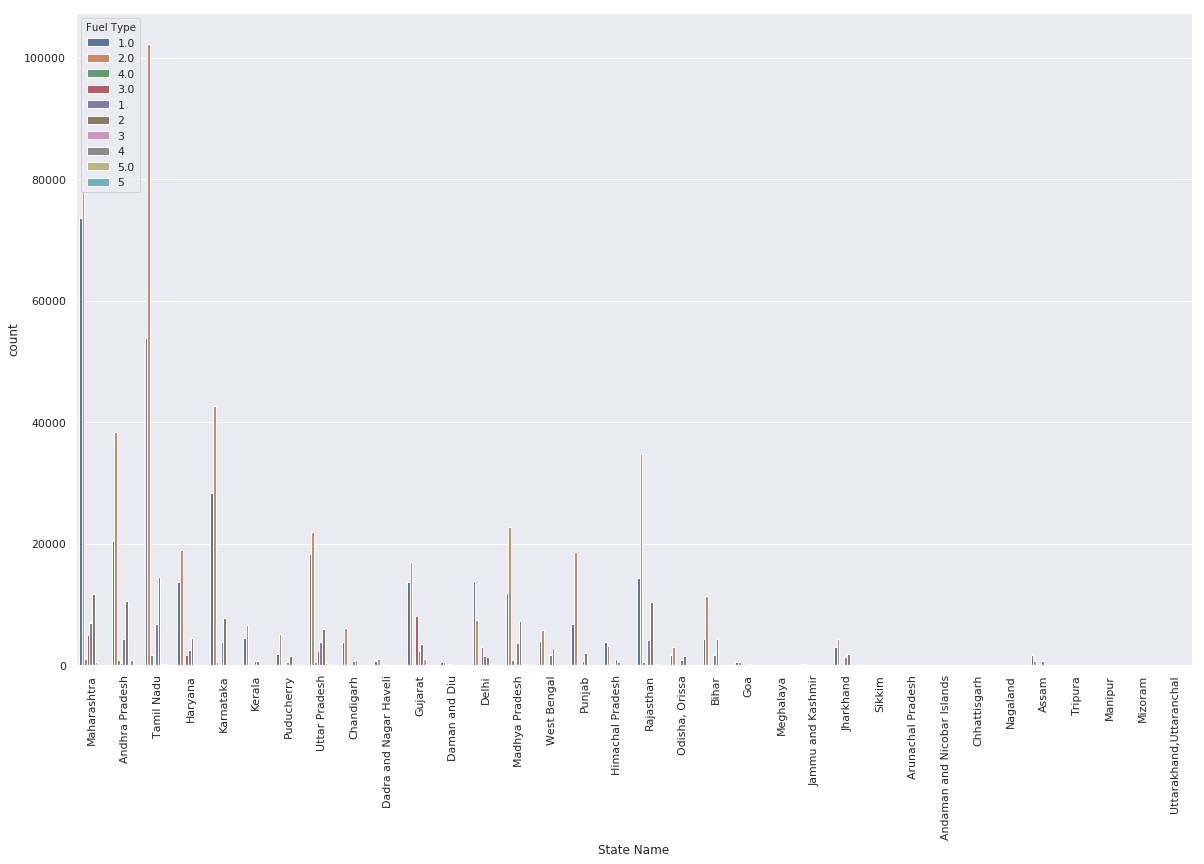

In [45]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 12))
sns.countplot(x="State Name", data=master_df,hue='Fuel Type')
plt.xticks(rotation='vertical')
plt.show()

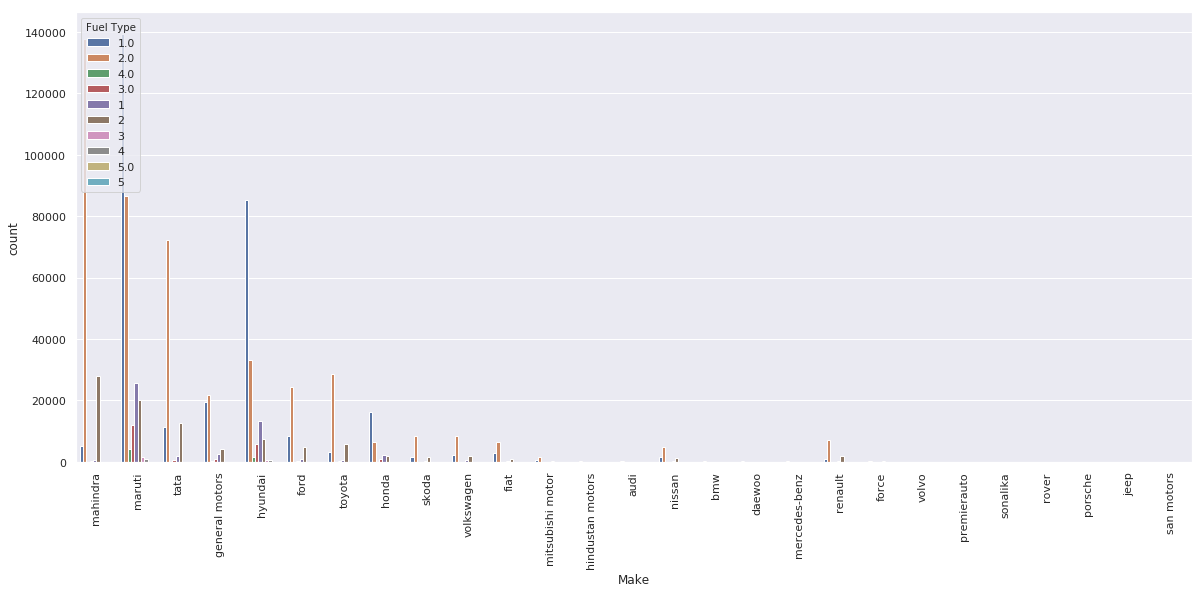

In [48]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 8.27))
sns.countplot(x="Make", data=master_df, hue='Fuel Type')
plt.xticks(rotation='vertical')
plt.show()

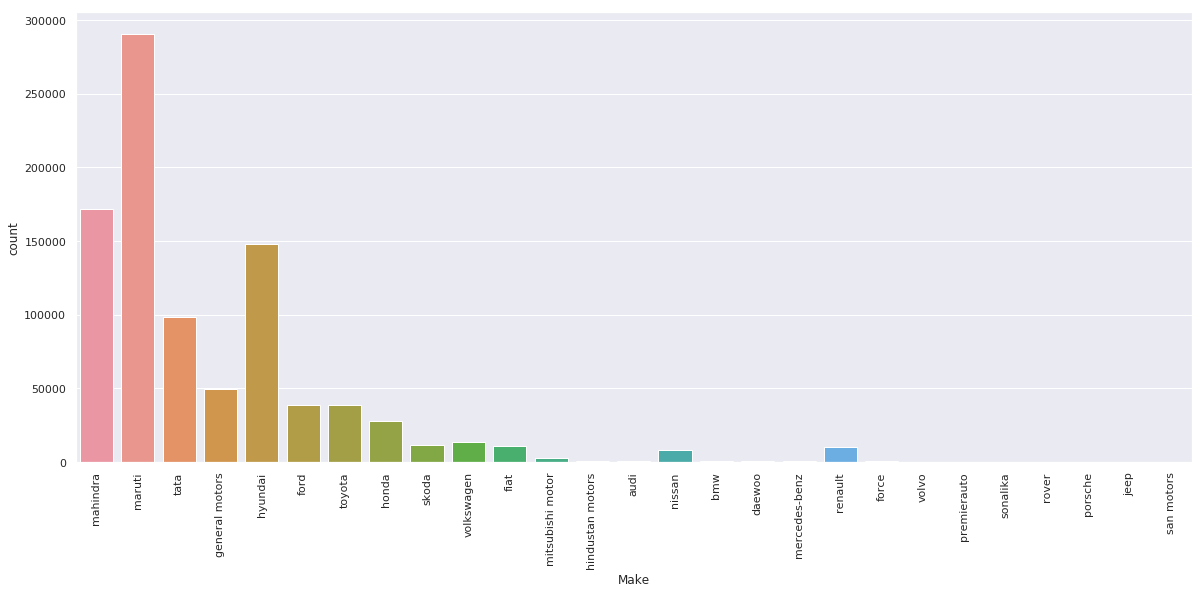

In [50]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(20, 8.27))
sns.countplot(x="Make", data=master_df)
plt.xticks(rotation='vertical')
plt.show()

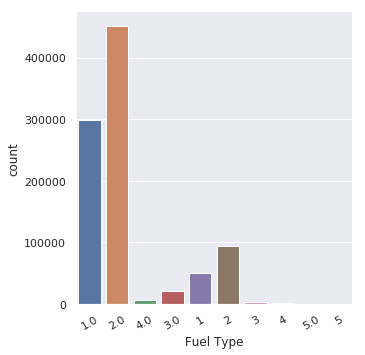

In [51]:
p = sns.factorplot('Fuel Type',data=dfmerged,kind='count')
p.set_xticklabels(rotation=30)

In [0]:
# combine Date & Time columns
def to_datetime(dataset, datetime_cols):
    for datetime in datetime_cols:
      dataset[datetime[0] + '-' + datetime[1]] = pd.to_datetime(dataset[datetime[0]]+ ' ' + dataset[datetime[1]])
    return dataset
datetime_cols = ['Invoice Date','Invoice Time','JobCard Date','JobCard Time']
master_df = to_datetime(master_df, [['Invoice Date','Invoice Time'],['JobCard Date','JobCard Time']])


#split datetime column
master_df['Year']  = master_df['Invoice Date-Invoice Time'].dt.year
master_df['Month'] = master_df['Invoice Date-Invoice Time'].dt.month


# add job duration column
def job_completion_time(dataset, start_datetime, end_datetime):
    dataset['Job_duration(in days)'] = (dataset[start_datetime] - dataset[end_datetime]) / np.timedelta64(1,'D')
    return dataset
master_df = job_completion_time(master_df, 'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time')


# add total all costs to get 'Total Expenses'
def sum_cols(dataset, cols_to_sum, result_col):
  dataset[result_col] = 0
  for col in cols_to_sum:
      dataset[result_col] = dataset[result_col] + dataset[col]
  return dataset
cost_cols     = ['Misc Total','OSL Total','Parts Total','Total Amt Wtd Tax.']
master_df =  sum_cols(master_df, cost_cols, 'Total_Expense')


#remove dulicate column Date-Time columns
master_df = drop_col(master_df, datetime_cols)
master_df = drop_col(master_df, cost_cols)

# drop unique value columns
unique_cols = ['User ID','Regn No','Pin code','Customer No.','Invoice No','Job Card No']
master_df = drop_col(master_df, unique_cols)

In [0]:
# map column description
def map_description(dataset,col, map_dict):
    dataset[col] = dataset[col].astype(str).map(map_dict)
    return dataset

data_origin_dict = { 'z001':'Camp-Outdoor','z002':'Camp-Workshop','z003':'Emailers',
                     'z004':'Fleet','z005':'Ref-Customer','z006':'Ref-Employee',
                     'z007':'Used Car Dealer','z008':'Just Dial/Other',
                     'z009':'Snapdeal/Web','z010':'Company website',
                     'z011':'Float activity','z012':'Petrol pump',
                     'z013':'Hoardings/ADVT','z014':'Insurance Co',
                     'z015':'Television AD','z016':'Newspaper AD',
                     'z017':'Newsppr leaflet','z018':'Sales Activity',
                     'z019':'Spotted outlet','z020':'M & M Employee',
                     'z021':'Outdoor Activty','z022':'Radio'
                  }

partner_type_dict = {'1.0':'Retail','2.0':'Corporate','3.0':'Fleet',
                     '4.0':'Employee','9001.0':'Insurance Company',
                     '9002.0':'Surveyor','9003.0':'Contact Person'
                    }

master_df = map_description(master_df,'Data Origin', data_origin_dict)
master_df = map_description(master_df,'Partner Type', partner_type_dict)

# change columns dtype

def modify_col_type(dataset, col, dtype):
    dataset[col] = dataset[col].astype(dtype)
    return dataset

master_df = modify_col_type(master_df, 'Fuel Type', int)

In [0]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns_master_df = numeric_features(master_df)
print("Numeric Features for master_df:")
print(numeric_columns_master_df)

numeric_columns_jtd_df = numeric_features(jtd_df)
print("Numeric Features for jtd_df:")
print(numeric_columns_jtd_df)

print("===="*30)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns_master_df = categorical_features(master_df)
print("Categorical Features for master_df:")
print(categorical_columns_master_df)

categorical_columns_jtd_df = categorical_features(jtd_df)
print("categorical Features for jtd_df:")
print(categorical_columns_jtd_df)

In [0]:
def display_unique_values(dataset, categirical_cols):
    print("Unique values: ")  
    for col in categirical_cols:
          print("{} : {}".format(col, dataset[col].unique()))
    return None
  
# display_unique_values(master_df, categorical_columns_master_df)   

# **Univariate Analysis**

In [0]:
def plot_CountPlot(dataset,col,title=None):
    filtered_df = dataset[col].value_counts()
    filtered_df=filtered_df.reset_index()
    filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
    filtered_df = filtered_df.sort_values(col)
    filtered_df = filtered_df[filtered_df[col]>1]
    plt.barh(filtered_df['index'],filtered_df[col])
    
    plt.style.use('seaborn')
    if(title==None):
        plt.title('Count plot for {}'.format(col))
    plt.xlabel('Percentage')
    plt.tight_layout()
    plt.show()
  
# plot_vc(master_df,'Data Origin','how customers know abt MFCS')
# plot_vc(master_df,'Make','Make wise distribution')
plot_CountPlot(master_df,'State')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'CITY','Citywise distribution in maharashtra')
# plot_vc(master_df[master_df['State'] == 'tamil nadu'],'CITY','Citywise distribution in TN')
# plot_vc(master_df,'Order Type','Order type distribution')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'Plant Name1','plant wise distribution in maharashtra')

In [0]:
def get_top_values(dataset,col,min_percentage):
    filtered_df = dataset[col].value_counts()
    filtered_df=filtered_df.reset_index()
    filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
    filtered_df = filtered_df.sort_values(col)
    filtered_df = filtered_df[filtered_df[col]>min_percentage]
    top_values  = filtered_df['index'].tolist()
    top_values_df = dataset[dataset[col].isin(top_values)]
    return top_values_df, top_values

def plot_TimeSeries(dataset, time_col, cat_col, num_col):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.title("'{}'wise '{}' in top '{}'".format(time_col, num_col, cat_col))
    dataset.groupby([time_col,cat_col])[num_col].sum().unstack().plot(ax=ax,marker='o')
    
top_state_df, top_state = get_top_values(master_df, 'State',1)
plot_TimeSeries(top_state_df,'Year','State','Total_Expense')

In [0]:
print("columns from invoice_df: ",set(master_df.columns) & set(invoice_df.columns))
print("columns from customer_df: ",set(master_df.columns) & set(customer_df.columns))
print("columns from plant_df: ",set(master_df.columns) & set(plant_df.columns))
print("columns from vehicles_df: ",set(master_df.columns) & set(vehicles_df.columns))

In [0]:
def scatter_plot(df,x,y):
  plt.style.use('seaborn')
  plt.scatter(df[x],df[y])
  #cbar=plt.colorbar()
  #cbar.set_label('Price variation')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title('{} vs {}'.format(x,y))
  plt.show()

scatter_plot(master_df,'Total_Expense','KMs Reading')

In [0]:
def plot_groupby(df,grpby_col, col):
  gp=df.groupby(grpby_col)[col].sum()
  gp=100*gp/sum(gp)
  gp=gp[gp>1]
  print(gp.index)
  gp.sort_values().plot(kind='barh')
  plt.style.use('fivethirtyeight')
  plt.title('{}wise Total {} percentage'.format(grpby_col, col))
  plt.xlabel('Percentage')
  plt.tight_layout()

plot_groupby(master_df,'Make','Total_Expense')

In [0]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
plt.style.use('fivethirtyeight')
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].count().plot(kind='pie',ax=ax[0])
plt.title('Countwise And Earningwise Order type distribution',loc='left')
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].sum().plot(kind='pie',ax=ax[1])
plt.tight_layout()
#plt.legend(loc='upper right')
plt.show()

In [0]:
# import sys
from string import punctuation
import sys

digits = []
correct_string = []
corrected_string = []
error_string = []
punctuation_string = []
not_corrected_string = []
top_city_df, top_cities = get_top_values(master_df, 'CITY',0.6)
top_cities.remove('nasik')

def remove_punctuation(string):
    try:
        string = ''.join([char for char in string if char not in punctuation])
    except:
        sys.exit(string)
    return string

def spellcorrect(string):
      if (string.isdigit()):
          digits.append(string)
          string = None
      elif(bool(re.match('[a-zA-Z]', string))):
          best_guess = process.extractOne(string, top_cities)
          if(len(string.split())<=2):
              if(best_guess[1]==100):
                  correct_string.append(string)
              elif(best_guess[1]>=80):
                  corrected_string.append(string)
              else:
                  not_corrected_string.append(string)
          elif(len(string.split())>2):
              if(best_guess[1]>=70):
                  corrected_string.append(string)
              else:
                  error_string.append(string)
                  string = None
      else:
          punctuation_string.append(string)
          string = None
      if(string!=None):
          string  = remove_punctuation(string)
      return string
          
def typo_check(dataset,col): 
    dataset['City'] = dataset[col].apply(spellcorrect)
    return dataset
  
cities_df = typo_check(master_df, 'CITY')

# not_corrected.sort()
# digits.sort()
# corrected_string.sort()

In [0]:
# user_input = "bangalore'"
# # best_guess = process.extractOne(user_input, top_cities)
# # if(best_guess[1]>67):
# #     print(f"The best match for '{user_input}' is '{best_guess[0]}' which is a {best_guess[1]}% match.")

# import string
# asking = "hello! what's your name?"
# asking = ''.join([char for char in user_input if char not in string.punctuation])
# asking

In [0]:
digits = sorted(set(digits))
correct_string = sorted(set(correct_string))
corrected_string = sorted(set(corrected_string))
not_corrected_string = sorted(set(not_corrected_string))
error_string = sorted(set(error_string))
punctuation_string = sorted(set(punctuation_string))

In [0]:
print(len(digits))
print(len(correct_string))
print(len(corrected_string))
print(len(error_string))
print(len(punctuation_string))
print(len(not_corrected_string))

In [0]:
from google.colab import files

cities_df.to_csv('cities_df.csv', index=False)
files.download('cities_df.csv')